In [1]:
import cv2
from ultralytics import YOLO
import socket
import threading
import pygame
import sys
import face_recognition
import numpy as np
from deepface import DeepFace # type: ignore
import math
import mediapipe as mp
from dollarpy import Recognizer, Template, Point
import pickle
import os



pygame 2.6.1 (SDL 2.28.4, Python 3.11.2)
Hello from the pygame community. https://www.pygame.org/contribute.html



Hand Geature

In [2]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Function to get points from a single frame
def getPointsFromFrame(frame):
    points = []

    with mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(image)

        # Process hand landmarks
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for landmark in hand_landmarks.landmark:
                    x, y = landmark.x, landmark.y
                    if not (np.isnan(x) or np.isnan(y)):
                        points.append(Point(x, y, stroke_id=0))
    return points

def loadTemplates(save_path):
    if os.path.exists(save_path):
        with open(save_path, 'rb') as f:
            return pickle.load(f)
    return []
# Main program
template_file = "gesture_templates_final.pkl"
if not os.path.exists(template_file):
    trainTemplates(template_file)

templates = loadTemplates(template_file)

# Initialize Recognizer with loaded templates
recognizer = Recognizer(templates)

Object detetiction

In [3]:
OBmodel = YOLO(r"best (2).pt")
target_class_names = ['Left', 'Past', 'Pyramid', 'Right', 'Tut']
target_classes = [index for index, name in OBmodel.names.items() if name in target_class_names]



In [4]:
def GetObject(frame):
    results = OBmodel(frame, conf=0.5, classes=target_classes) 
    result = results[0]
    if len(result.boxes.cls) > 0:
        for box, score, cls in zip(result.boxes.xywh, result.boxes.conf, result.boxes.cls):
            class_name = OBmodel.names[int(cls)]  
            confidence = float(score) 
            return class_name



Socket

In [5]:
HOST = '127.0.0.1'
PORT = 65479

In [6]:
# Declare global variables
parts = []
object_id = None
angle = None
previous_angle = None
rotation_state = None  # Current direction: 'right', 'left', or None
starting_angle = None  # Tracks the initial angle of a potential rotation
angle_threshold = .09  # Minimum angle difference to register a rotation

def handle_client(conn, addr):
    global parts, object_id, angle, previous_angle, rotation_state, starting_angle
    print(f"Connected by {addr}")
    
    while True:
        data = conn.recv(1024)
        if not data:
            break
        
        # Decode and strip whitespace
        message = data.decode().strip()
        print(f"Received from {addr}: {message}")
        
        # Split the message into parts
        try:
            parts = message.split()
            if len(parts) == 2:
                object_id, angle = parts
                angle = float(angle)  # Convert to float for numerical comparison
                
                if previous_angle is not None:
                    angle_change = angle - previous_angle
                    
                    if abs(angle_change) >= angle_threshold:  # Check if change exceeds the threshold
                        if angle_change > 0:  # Moving to the right
                            if rotation_state == "left":  # If previously moving left
                                rotation_state = None  # Reset state
                                starting_angle = None  # Reset starting angle
                            else:
                                if rotation_state is None:
                                    starting_angle = previous_angle  # Set starting angle
                                rotation_state = "right"
                        elif angle_change < 0:  # Moving to the left
                            if rotation_state == "right":  # If previously moving right
                                rotation_state = None  # Reset state
                                starting_angle = None  # Reset starting angle
                            else:
                                if rotation_state is None:
                                    starting_angle = previous_angle  # Set starting angle
                                rotation_state = "left"

                    # Check if we've returned to the starting angle
                    if starting_angle is not None:
                        if rotation_state == "right" and angle <= starting_angle:
                            rotation_state = None
                            starting_angle = None
                        elif rotation_state == "left" and angle >= starting_angle:
                            rotation_state = None
                            starting_angle = None
                
                previous_angle = angle  # Update the previous angle
            else:
                print(f"Invalid message format: {message}")
                object_id = None
        except Exception as e:
            print(f"Error processing message: {e}")
        
        response = (
            f"Received Object ID: {object_id}, Angle: {angle}"
            if len(parts) == 2 else "Invalid message format"
        )
        conn.sendall(response.encode())
    
    conn.close()
    print(f"Connection closed for {addr}")



    

def start_server():
    server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_socket.bind((HOST, PORT))
    server_socket.listen()
    print(f"Server listening on {HOST}:{PORT}...")
    
    while True:
        conn, addr = server_socket.accept()
        client_thread = threading.Thread(target=handle_client, args=(conn, addr))
        client_thread.start()




Face Recegonintion

In [7]:
def load_faces():
    known_face_encodings = []
    image1 = cv2.imread("imgs/IMG_6189.JPG")
    image2 = cv2.imread("imgs/IMG_6879.JPG")

    image1_encoding = face_recognition.face_encodings(image1)[0]
    image2_encoding = face_recognition.face_encodings(image2)[0]

    known_face_encodings.append(image1_encoding)
    known_face_encodings.append(image2_encoding)

    known_face_names = ["jojo","soso"]

    return known_face_encodings, known_face_names

def Recognition(rgb_small_frame,known_face_encodings,known_face_names):
    # Find all face locations and face encodings in the current frame
    face_locations = face_recognition.face_locations(rgb_small_frame)
    face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)
    face_names = []
    for face_encoding in face_encodings:
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
        name = "Unknown"

        face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
        best_match_index = np.argmin(face_distances)
        if matches[best_match_index]:
            name = known_face_names[best_match_index]

        face_names.append(name)

    return face_locations, face_names

    
known_face_encodings, known_face_names = load_faces()


Face Emotions

In [12]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [13]:
persons = []
emotion_list = []  
objectD = ""
gesture_name = ""
def allModels():
    global objectD
    global persons,gesture_name
    cap = cv2.VideoCapture(1)
    framecnt=0



    if not cap.isOpened():
        print("Error: Could not open the camera.")
        exit()


    while True:
        ret, frame = cap.read()
        if not ret:
            break



        small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
        rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)
        face_locations, face_names = Recognition(rgb_small_frame, known_face_encodings, known_face_names)
        if face_names:
            persons = face_names

        if framecnt % 6 == 0: 
            objectD = GetObject(small_frame)
            # print(f"object: {objectD}")



        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        for (x, y, w, h) in faces:

            face = frame[y:y+h, x:x+w]

            result = DeepFace.analyze(face, actions=['emotion'], enforce_detection=False)

            dominant_emotion = result[0]['dominant_emotion']
            emotion_list.append(dominant_emotion)

        framecnt +=1

        # if objectD == None and object_id == None :
        #     points = getPointsFromFrame(frame)
        #     x_values = [p.x for p in points]
        #     y_values = [p.y for p in points]

        #     if points and (max(x_values) - min(x_values) != 0) and (max(y_values) - min(y_values) != 0):
        #         result = recognizer.recognize(points)

        #         if result:
        #             best_match = result[0]
        #             gesture_name = best_match
        #             cv2.putText(frame, f"Gesture: {gesture_name}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        #         else:
        #             cv2.putText(frame, "No gesture detected", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)





        cv2.imshow("Smart Museum", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    
    text_filename = "emotions.txt"
    with open(text_filename, mode='w') as file:
        file.write("Frame\tEmotion\n")  # Write header
        for i, emotion in enumerate(emotion_list):
            file.write(f"{i + 1}\t{emotion}\n")  # Write each frame and emotion
    filename = "emotions.txt"  # Make sure this matches your saved file
    emotion_data = analyze_emotions_from_file(filename)
    plot_emotions(emotion_data)


File


In [14]:
import matplotlib.pyplot as plt
from collections import Counter

def analyze_emotions_from_file(filename):
    """Read emotions from a file and analyze their frequency."""
    emotions = []
    
    # Read the file and extract emotions
    with open(filename, 'r') as file:
        # Skip the header
        next(file)
        for line in file:
            _, emotion = line.strip().split("\t")  # Split by tab
            emotions.append(emotion)
    
    # Count the frequency of each emotion
    emotion_counts = Counter(emotions)
    
    return emotion_counts

def plot_emotions(emotion_counts):
    """Plot a pie chart of emotion frequencies."""
    emotions = list(emotion_counts.keys())
    counts = list(emotion_counts.values())

    # Create a pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(
        counts,
        labels=emotions,
        autopct="%1.1f%%",  # Display percentage with 1 decimal place
        startangle=140,  # Rotate the pie chart for better readability
        colors=plt.cm.Paired.colors,  # Use a color map for better visuals
    )
    plt.title("Emotion Analysis")
    plt.axis("equal")  # Ensure the pie chart is circular

    # Show the chart in a new window
    plt.show()




In [15]:
def save_person(name, language, filename="data.txt"):
    """Save person's name and chosen language to a file."""
    with open(filename, "a") as file:  # Append mode to add data without overwriting
        file.write(f"\n{name}, {language}\n")  # Save as 'name, language'
    print(f"Saved: {name} - {language}")

def load_person_data(name_to_search,filename="data.txt"):
    try:
        with open(filename, 'r') as file:
            for line in file:
                name, language = line.strip().split(', ')
                if name == name_to_search:
                    return language
        return False
    except FileNotFoundError:
        return "File not found."

def search_name(name_to_search,filename="data.txt") :
    try:
        with open(filename, 'r') as file:
            for line in file:
                name, language = line.strip().split(', ')
                if name == name_to_search:
                    return True
        return False
    except FileNotFoundError:
        return "File not found."




PyGame

In [16]:
COLORS = [
    (0, 0, 0),  # Brown for Info
    (0, 0, 0),  # Brown for Story
    (0, 0, 0),  # Brown for Gallery
]
HIGHLIGHT_COLOR = (139, 69, 19)  # White for highlighting

# Pie menu data
MENU_ITEMS = 3
OPTIONS = []
current_menu_index = 0
CENTER = (1200, 200)
RADIUS = 100

def draw_pie_menu(selected_index):
    global OPTIONS
    """Draws the pie menu with the selected slice highlighted and labeled."""
    angle_step = 360 / MENU_ITEMS
    start_angle = 0

    # Draw the "Menu" label above the pie
    draw_text("Menu", (CENTER[0], CENTER[1] - RADIUS - 40), 36, (255, 255, 255))

    for i in range(MENU_ITEMS):
        end_angle = start_angle + angle_step
        color = HIGHLIGHT_COLOR if i == selected_index else COLORS[i]

        # Draw pie slice
        draw_pie_slice(CENTER, RADIUS, start_angle, end_angle, color)

        # Add text label inside the pie slice
        label_angle = (start_angle + end_angle) / 2
        draw_text_on_slice(CENTER, RADIUS, label_angle, OPTIONS[i])

        start_angle = end_angle


def draw_pie_slice(center, radius, start_angle, end_angle, color):
    """Draws a single pie slice."""
    # Convert angles to radians
    start_angle_rad = math.radians(start_angle)
    end_angle_rad = math.radians(end_angle)

    # Create points for the pie slice
    points = [center]
    for angle in range(int(start_angle), int(end_angle) + 1):
        angle_rad = math.radians(angle)
        x = int(center[0] + radius * math.cos(angle_rad))
        y = int(center[1] + radius * math.sin(angle_rad))
        points.append((x, y))

    # Draw polygon for the pie slice
    pygame.draw.polygon(screen, color, points)


def draw_text_on_slice(center, radius, angle, text):
    """Draws text in the center of a pie slice."""
    angle_rad = math.radians(angle)
    text_x = int(center[0] + (radius / 1.5) * math.cos(angle_rad))
    text_y = int(center[1] + (radius / 1.5) * math.sin(angle_rad))

    font = pygame.font.Font(None, 24)  # Default font with a smaller size
    text_surface = font.render(text, True, (255, 255, 255))  # White text
    text_rect = text_surface.get_rect(center=(text_x, text_y))
    screen.blit(text_surface, text_rect)


def draw_text(text, position, font_size, color):
    """Draws text on the screen at the specified position."""
    font = pygame.font.Font(None, font_size)  # Default font
    text_surface = font.render(text, True, color)
    text_rect = text_surface.get_rect(center=position)
    screen.blit(text_surface, text_rect)

def update_menu_selection(direction):
    """Updates the selected menu item based on rotation direction."""
    global current_menu_index

    if direction == "right":
        current_menu_index = (current_menu_index + 1) % MENU_ITEMS
    elif direction == "left":
        current_menu_index = (current_menu_index - 1) % MENU_ITEMS

In [ ]:
#######################################################3


import pygame
import math

lang = "n"
known = False
person = None
face_exist = False
object_exsit = False
o =""
go = 0
gesture_name = None

# Initialize Pygame
pygame.init()
server_thread = threading.Thread(target=start_server, daemon=True)
server_thread.start()
    
all_thread = threading.Thread(target=allModels, daemon=True)
all_thread.start()
# Screen dimensions
display_info = pygame.display.Info()
SCREEN_WIDTH, SCREEN_HEIGHT = display_info.current_w-10, display_info.current_h-60
# SCREEN_WIDTH, SCREEN_HEIGHT = 600,600

    # Set up the display
screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))


# Main game loop
running = True
clock = pygame.time.Clock()
rotation_direction = None

server_thread = threading.Thread(target=start_server, daemon=True)
server_thread.start()

screen.blit(pygame.image.load("welcome.png"), (0, 0))
pygame.display.flip()  
pygame.time.delay(2000)



while running:
    
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_ESCAPE:
                running = False



    if face_exist== False:
        if persons:
            print(persons)
            person = persons[0]
            if search_name(person):
                known = True
            face_exist = True

    if face_exist:
        if known:
            lang = load_person_data(person)


    

    if lang == "n":
        print(objectD)
        image = pygame.image.load("language (1).png")
        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))

        # Blit the scaled image to the screen
        screen.blit(scaled_image, (0, 0))
        pygame.display.flip()
        if rotation_state == "right" or objectD== "Right" or gesture_name == "right":
            lang = "a"
            save_person("soso",lang)
            if gesture_name == "right":
                gesture_name= None

            rotation_state = None 
             
        elif rotation_state == "left" or objectD == "Left" or gesture_name == "left":
            lang = "e"
            save_person("soso",lang)

            rotation_state = None 
            if gesture_name == "left":
                gesture_name= None




    elif lang == "e":
       
                
        OPTIONS = ["Info", "Story", "Gallery"]
        if object_exsit == False:

            image = pygame.image.load("lace object.png")
            scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))

            # Blit the scaled image to the screen
            screen.blit(scaled_image, (0, 0))

            
            pygame.display.flip()

            if(objectD in ["Past", "Tut", "Pyramid"]) or (object_id in ["1","2","3"] or gesture_name=="peace"):
                object_exsit= True
                if gesture_name == "peace":
                    go = 1
                    gesture_name = None
                
                

        elif object_exsit:
            # if gesture_name =="peace":
            #     go+=1
            #     if go==4:
            #         go=1

            if rotation_state == "right" or objectD== "Right" or  gesture_name == "right":
                update_menu_selection("right")
                draw_pie_menu(current_menu_index)
                pygame.display.flip()
                rotation_state= None
                if objectD =="Right":
                    objectD = None
                if gesture_name == "right":
                    gesture_name = None

            elif rotation_state == "left" or objectD == "Left" or gesture_name == "left":
                update_menu_selection("left")
                draw_pie_menu(current_menu_index)
                pygame.display.flip()
                rotation_state= None
                if objectD =="Left":
                    objectD =None
                if gesture_name == "left":
                    gesture_name = None


            if objectD == "Tut" or object_id =="1" or go==1:
                current_menu_index=0
                draw_pie_menu(current_menu_index)
                pygame.display.flip()
                gesture_name = None
                pygame.display.set_caption("Tut")
                o = "tut"


            elif objectD == "Past" or object_id =="2" or go==2:
                current_menu_index=0
                gesture_name = None
                draw_pie_menu(current_menu_index)
                pygame.display.flip()

                pygame.display.set_caption("Past")
                pygame.display.flip()

                o = "past"

            elif objectD == "Pyramid" or object_id =="3" or go==3:
                current_menu_index=0
                gesture_name = None
                draw_pie_menu(current_menu_index)
                pygame.display.flip()

                pygame.display.set_caption("Pyramid")
                pygame.display.flip()

                o= "pyr"

            if o =="tut":   
                if current_menu_index == 0:
                    image = pygame.image.load("tot eng info.png")
                    scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                    screen.blit(scaled_image, (0, 0))

                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()
                
                if current_menu_index == 1:
                    image = pygame.image.load("tut story eng.png")
                    scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                    screen.blit(scaled_image, (0, 0))


                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()

                if current_menu_index == 2:
                    image = pygame.image.load("tot eng gallery.png")
                    scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                    screen.blit(scaled_image, (0, 0))

                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()
            
            elif o =="past":   
                if current_menu_index == 0:
                    image = pygame.image.load("bastet eng info.png")
                    scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                    screen.blit(scaled_image, (0, 0))


                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()
                
                if current_menu_index == 1:

                    image = pygame.image.load("bastet eng story.png")
                    scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                    screen.blit(scaled_image, (0, 0))



                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()

                if current_menu_index == 2:

                    image = pygame.image.load("Pastet eng gallery.png")
                    scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                    screen.blit(scaled_image, (0, 0))

                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()


            elif o =="pyr":   
                if current_menu_index == 0:

                    image = pygame.image.load("khofo eng info.png")
                    scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                    screen.blit(scaled_image, (0, 0))

                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()
                
                if current_menu_index == 1:

                    image = pygame.image.load("khofo eng story.png")
                    scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                    screen.blit(scaled_image, (0, 0))

                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()

                if current_menu_index == 2:
                    image = pygame.image.load("khofo eng gallery.png")
                    scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                    screen.blit(scaled_image, (0, 0))


                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()


    
    elif lang =="a":
        if gesture_name =="peace":
            go+=1
            if go==4:
                go=1
            gesture_name =None
        OPTIONS = ["معلومات", "قصه", "معرض"]

        if object_exsit == False:
            screen.blit(pygame.image.load("lace object.png"), (0, 0))
            pygame.display.flip()

            if object_exsit == (objectD in ["Past", "Tut", "Pyramid"]) or (object_id in ["1","2","3"] or gesture_name=="peace"):
                object_exsit= True
                if gesture_name == "peace":
                    go = 1
                # draw_pie_menu(current_menu_index)
                
        else:

            if rotation_state == "right" or objectD== "Right" or gesture_name == "right":
                update_menu_selection("right")
                draw_pie_menu(current_menu_index)
                pygame.display.flip()
                if objectD =="Right":
                    objectD = None
                if gesture_name == "right":
                    gesture_name = None
                rotation_state= None

            elif rotation_state == "left" or objectD == "Left" or gesture_name == "left":
                update_menu_selection("left")
                draw_pie_menu(current_menu_index)
                pygame.display.flip()
                if objectD =="Left":
                    objectD = None
                if gesture_name == "left":
                    gesture_name = None
                rotation_state= None


            if objectD == "Tut" or object_id =="1" or go==1:
                current_menu_index=0
                gesture_name = None
                draw_pie_menu(current_menu_index)
                pygame.display.flip()

                pygame.display.set_caption("Tut")
                o = "tut"


            elif objectD == "Past" or object_id =="2" or go==2:
                current_menu_index=0
                gesture_name = None
                draw_pie_menu(current_menu_index)
                pygame.display.flip()

                pygame.display.set_caption("Past")
                pygame.display.flip()

                o = "past"

            elif objectD == "Pyramid" or object_id =="3" or go==3:
                current_menu_index=0
                gesture_name = None
                draw_pie_menu(current_menu_index)
                pygame.display.flip()

                pygame.display.set_caption("Pyramid")
                pygame.display.flip()

                o= "pyr"

            if o =="tut":   
                if current_menu_index == 0:
                    screen.blit(pygame.image.load("tot eng info.png"), (0, 0))
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()
                
                if current_menu_index == 1:
                    screen.blit(pygame.image.load("tut story eng.png"), (0, 0))
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()

                if current_menu_index == 2:
                    screen.blit(pygame.image.load("tot eng gallery.png"), (0, 0))
                    pygame.display.flip()
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()
            
            elif o =="past":   
                if current_menu_index == 0:
                    screen.blit(pygame.image.load("bastet eng info.png"), (0, 0))
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()
                
                if current_menu_index == 1:
                    screen.blit(pygame.image.load("bastet eng story.png"), (0, 0))
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()

                if current_menu_index == 2:
                    screen.blit(pygame.image.load("Pastet eng gallery.png"), (0, 0))
                    pygame.display.flip()
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()


            elif o =="pyr":   
                if current_menu_index == 0:
                    screen.blit(pygame.image.load("khofo eng info.png"), (0, 0))
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()
                
                if current_menu_index == 1:
                    screen.blit(pygame.image.load("khofo eng story.png"), (0, 0))
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()

                if current_menu_index == 2:
                    screen.blit(pygame.image.load("khofo eng gallery.png"), (0, 0))
                    pygame.display.flip()
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()

        


    # update_menu_selection("left")

    #draw_pie_menu(current_menu_index)

    #pygame.display.flip()


    # Draw the pie menu
    #draw_pie_menu(current_menu_index)

    # Update the display
    #pygame.display.flip()
    # clock.tick(30)

pygame.quit()

pygame 2.6.1 (SDL 2.28.4, Python 3.11.2)
Hello from the pygame community. https://www.pygame.org/contribute.html



Exception in thread Thread-5 (start_server):
Traceback (most recent call last):
  File "c:\Users\sohila\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\sohila\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\sohila\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\sohila\AppData\Local\Temp\ipykernel_26244\4192576922.py", line 154, in start_server
OSError: [WinError 10048] Only one usage of each socket address (protocol/network address/port) is normally permitted


Server listening on 127.0.0.1:65479...

0: 480x640 (no detections), 83.9ms
Speed: 2.9ms preprocess, 83.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
object: None

0: 480x640 (no detections), 136.9ms
Speed: 2.0ms preprocess, 136.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
object: None

0: 480x640 (no detections), 137.2ms
Speed: 2.0ms preprocess, 137.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
object: None

0: 480x640 (no detections), 119.1ms
Speed: 4.0ms preprocess, 119.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
object: None

0: 480x640 (no detections), 149.5ms
Speed: 3.1ms preprocess, 149.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
object: None

0: 480x640 (no detections), 123.5ms
Speed: 3.0ms preprocess, 123.5ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)
object: None

0: 480x640 (no detections), 136.1ms
Speed: 3.0ms preprocess, 136.1ms infer

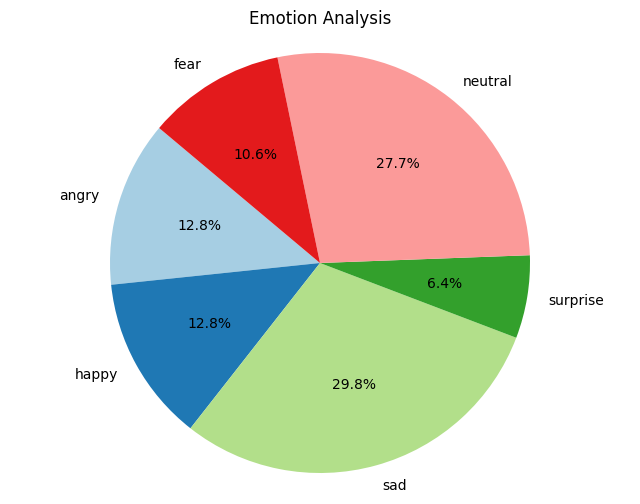

In [1]:
import cv2
from ultralytics import YOLO
import socket
import threading
import pygame
import sys
import face_recognition
import numpy as np
from deepface import DeepFace # type: ignore
import math
import mediapipe as mp
from dollarpy import Recognizer, Template, Point
import pickle
import os
from bidi.algorithm import get_display
import arabic_reshaper


mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Function to get points from a single frame
def getPointsFromFrame(frame):
    points = []

    with mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(image)

        # Process hand landmarks
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for landmark in hand_landmarks.landmark:
                    x, y = landmark.x, landmark.y
                    if not (np.isnan(x) or np.isnan(y)):
                        points.append(Point(x, y, stroke_id=0))
    return points

def loadTemplates(save_path):
    if os.path.exists(save_path):
        with open(save_path, 'rb') as f:
            return pickle.load(f)
    return []
# Main program
template_file = "gesture_templates_final.pkl"
if not os.path.exists(template_file):
    trainTemplates(template_file)

templates = loadTemplates(template_file)

# Initialize Recognizer with loaded templates
recognizer = Recognizer(templates)


OBmodel = YOLO(r"best (2).pt")
target_class_names = ['Left', 'Past', 'Pyramid', 'Right', 'Tut']
target_classes = [index for index, name in OBmodel.names.items() if name in target_class_names]


def GetObject(frame):
    results = OBmodel(frame, conf=0.5, classes=target_classes) 
    result = results[0]
    if len(result.boxes.cls) > 0:
        for box, score, cls in zip(result.boxes.xywh, result.boxes.conf, result.boxes.cls):
            class_name = OBmodel.names[int(cls)]  
            confidence = float(score) 
            return class_name



HOST = '127.0.0.1'
PORT = 65479
# Declare global variables
parts = []
object_id = None
angle = None
previous_angle = None
rotation_state = None  # Current direction: 'right', 'left', or None
starting_angle = None  # Tracks the initial angle of a potential rotation
angle_threshold = .09  # Minimum angle difference to register a rotation

def handle_client(conn, addr):
    global parts, object_id, angle, previous_angle, rotation_state, starting_angle
    print(f"Connected by {addr}")
    
    while True:
        data = conn.recv(1024)
        if not data:
            break
        
        # Decode and strip whitespace
        message = data.decode().strip()
        print(f"Received from {addr}: {message}")
        
        # Split the message into parts
        try:
            parts = message.split()
            if len(parts) == 2:
                object_id, angle = parts
                angle = float(angle)  # Convert to float for numerical comparison
                
                if previous_angle is not None:
                    angle_change = angle - previous_angle
                    
                    if abs(angle_change) >= angle_threshold:  # Check if change exceeds the threshold
                        if angle_change > 0:  # Moving to the right
                            if rotation_state == "left":  # If previously moving left
                                rotation_state = None  # Reset state
                                starting_angle = None  # Reset starting angle
                            else:
                                if rotation_state is None:
                                    starting_angle = previous_angle  # Set starting angle
                                rotation_state = "right"
                        elif angle_change < 0:  # Moving to the left
                            if rotation_state == "right":  # If previously moving right
                                rotation_state = None  # Reset state
                                starting_angle = None  # Reset starting angle
                            else:
                                if rotation_state is None:
                                    starting_angle = previous_angle  # Set starting angle
                                rotation_state = "left"

                    # Check if we've returned to the starting angle
                    if starting_angle is not None:
                        if rotation_state == "right" and angle <= starting_angle:
                            rotation_state = None
                            starting_angle = None
                        elif rotation_state == "left" and angle >= starting_angle:
                            rotation_state = None
                            starting_angle = None
                
                previous_angle = angle  # Update the previous angle
            else:
                print(f"Invalid message format: {message}")
                object_id = None
        except Exception as e:
            print(f"Error processing message: {e}")
        
        response = (
            f"Received Object ID: {object_id}, Angle: {angle}"
            if len(parts) == 2 else "Invalid message format"
        )
        conn.sendall(response.encode())
    
    conn.close()
    print(f"Connection closed for {addr}")



    

def start_server():
    server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_socket.bind((HOST, PORT))
    server_socket.listen()
    print(f"Server listening on {HOST}:{PORT}...")
    
    while True:
        conn, addr = server_socket.accept()
        client_thread = threading.Thread(target=handle_client, args=(conn, addr))
        client_thread.start()



def load_faces():
    known_face_encodings = []
    image1 = cv2.imread("imgs/IMG_6189.JPG")
    image2 = cv2.imread("imgs/IMG_6879.JPG")

    image1_encoding = face_recognition.face_encodings(image1)[0]
    image2_encoding = face_recognition.face_encodings(image2)[0]

    known_face_encodings.append(image1_encoding)
    known_face_encodings.append(image2_encoding)

    known_face_names = ["jojo","soso"]

    return known_face_encodings, known_face_names

def Recognition(rgb_small_frame,known_face_encodings,known_face_names):
    # Find all face locations and face encodings in the current frame
    face_locations = face_recognition.face_locations(rgb_small_frame)
    face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)
    face_names = []
    for face_encoding in face_encodings:
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
        name = "Unknown"

        face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
        best_match_index = np.argmin(face_distances)
        if matches[best_match_index]:
            name = known_face_names[best_match_index]

        face_names.append(name)

    return face_locations, face_names

    
known_face_encodings, known_face_names = load_faces()

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
persons = []
emotion_list = []  
objectD = ""
gesture_name = ""
def allModels():
    global objectD
    global persons,gesture_name
    cap = cv2.VideoCapture(0)
    framecnt=0
    #cameraaaa



    if not cap.isOpened():
        print("Error: Could not open the camera.")
        exit()


    while True:
        ret, frame = cap.read()
        if not ret:
            break



        small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
        rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)
        face_locations, face_names = Recognition(rgb_small_frame, known_face_encodings, known_face_names)
        if face_names:
            persons = face_names

        if framecnt % 4 == 0: 
            objectD = GetObject(small_frame)
            print(f"object: {objectD}")



        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        for (x, y, w, h) in faces:

            face = frame[y:y+h, x:x+w]

            result = DeepFace.analyze(face, actions=['emotion'], enforce_detection=False)

            dominant_emotion = result[0]['dominant_emotion']
            emotion_list.append(dominant_emotion)


        # if objectD == None and object_id == None :
        if framecnt % 5 == 0: 
            points = getPointsFromFrame(frame)
            x_values = [p.x for p in points]
            y_values = [p.y for p in points]

            if points and (max(x_values) - min(x_values) != 0) and (max(y_values) - min(y_values) != 0):
                result = recognizer.recognize(points)

                if result:
                    best_match = result[0]
                    gesture_name = best_match
                    cv2.putText(frame, f"Gesture: {gesture_name}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                else:
                    cv2.putText(frame, "No gesture detected", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)


        framecnt +=1



        cv2.imshow("Smart Museum", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    
    text_filename = "emotions.txt"
    with open(text_filename, mode='w') as file:
        file.write("Frame\tEmotion\n")  # Write header
        for i, emotion in enumerate(emotion_list):
            file.write(f"{i + 1}\t{emotion}\n")  # Write each frame and emotion
    filename = "emotions.txt"  # Make sure this matches your saved file
    emotion_data = analyze_emotions_from_file(filename)
    plot_emotions(emotion_data)


import matplotlib.pyplot as plt
from collections import Counter

def analyze_emotions_from_file(filename):
    """Read emotions from a file and analyze their frequency."""
    emotions = []
    
    # Read the file and extract emotions
    with open(filename, 'r') as file:
        # Skip the header
        next(file)
        for line in file:
            _, emotion = line.strip().split("\t")  # Split by tab
            emotions.append(emotion)
    
    # Count the frequency of each emotion
    emotion_counts = Counter(emotions)
    
    return emotion_counts

def plot_emotions(emotion_counts):
    """Plot a pie chart of emotion frequencies."""
    emotions = list(emotion_counts.keys())
    counts = list(emotion_counts.values())

    # Create a pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(
        counts,
        labels=emotions,
        autopct="%1.1f%%",  # Display percentage with 1 decimal place
        startangle=140,  # Rotate the pie chart for better readability
        colors=plt.cm.Paired.colors,  # Use a color map for better visuals
    )
    plt.title("Emotion Analysis")
    plt.axis("equal")  # Ensure the pie chart is circular

    # Show the chart in a new window
    plt.show()



def save_person(name, language, filename="data.txt"):
    """Save person's name and chosen language to a file."""
    with open(filename, "a") as file:  # Append mode to add data without overwriting
        file.write(f"\n{name}, {language}\n")  # Save as 'name, language'
    print(f"Saved: {name} - {language}")

def load_person_data(name_to_search,filename="data.txt"):
    try:
        with open(filename, 'r') as file:
            for line in file:
                name, language ,role= line.strip().split(', ')
                if name == name_to_search:
                    return name , language , role
        return False
    except FileNotFoundError:
        return "File not found."

def search_name(name_to_search,filename="data.txt") :
    try:
        with open(filename, 'r') as file:
            for line in file:
                name, language ,role= line.strip().split(', ')
                if name == name_to_search:
                    return True
        return False
    except FileNotFoundError:
        return "File not found."




COLORS = [
    (0, 0, 0),  # Brown for Info
    (0, 0, 0),  # Brown for Story
    (0, 0, 0),  # Brown for Gallery
]
HIGHLIGHT_COLOR = (139, 69, 19)  # White for highlighting

# Pie menu data
MENU_ITEMS = 3
OPTIONS = []
current_menu_index = 0
CENTER = (1200, 150)
RADIUS = 100

def draw_pie_menu(selected_index):
    global OPTIONS
    """Draws the pie menu with the selected slice highlighted and labeled."""
    angle_step = 360 / MENU_ITEMS
    start_angle = 0

    # Draw the "Menu" label above the pie
    draw_text("Menu", (CENTER[0], CENTER[1] - RADIUS - 40), 36, (255, 255, 255))

    for i in range(MENU_ITEMS):
        end_angle = start_angle + angle_step
        color = HIGHLIGHT_COLOR if i == selected_index else COLORS[i]

        # Draw pie slice
        draw_pie_slice(CENTER, RADIUS, start_angle, end_angle, color)

        # Add text label inside the pie slice
        label_angle = (start_angle + end_angle) / 2
        draw_text_on_slice(CENTER, RADIUS, label_angle, OPTIONS[i])

        start_angle = end_angle


def draw_pie_slice(center, radius, start_angle, end_angle, color):
    """Draws a single pie slice."""
    # Convert angles to radians
    start_angle_rad = math.radians(start_angle)
    end_angle_rad = math.radians(end_angle)

    # Create points for the pie slice
    points = [center]
    for angle in range(int(start_angle), int(end_angle) + 1):
        angle_rad = math.radians(angle)
        x = int(center[0] + radius * math.cos(angle_rad))
        y = int(center[1] + radius * math.sin(angle_rad))
        points.append((x, y))

    # Draw polygon for the pie slice
    pygame.draw.polygon(screen, color, points)


def draw_text_on_slice(center, radius, angle, text):
    """Draws text in the center of a pie slice."""
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)

    angle_rad = math.radians(angle)
    text_x = int(center[0] + (radius / 1.5) * math.cos(angle_rad))
    text_y = int(center[1] + (radius / 1.5) * math.sin(angle_rad))

    font = pygame.font.Font("Cairo-VariableFont_slnt,wght.ttf", 21)  # Replace with your Arabic font
    text_surface = font.render(bidi_text, True, (255, 255, 255))
    text_rect = text_surface.get_rect(center=(text_x, text_y))
    screen.blit(text_surface, text_rect)

    # font = pygame.font.Font(None, 24)  # Default font with a smaller size
    # text_surface = font.render(text, True, (255, 255, 255))  # White text
    # text_rect = text_surface.get_rect(center=(text_x, text_y))
    # screen.blit(text_surface, text_rect)


def draw_text(text, position, font_size, color):
    """Draws text on the screen at the specified position."""
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    
    font = pygame.font.Font("Cairo-VariableFont_slnt,wght.ttf", 21)  # Replace with your Arabic font
    text_surface = font.render(bidi_text, True, (255, 255, 255))
    text_rect = text_surface.get_rect(center=position)
    screen.blit(text_surface, text_rect)

def update_menu_selection(direction):
    """Updates the selected menu item based on rotation direction."""
    global current_menu_index

    if direction == "right":
        current_menu_index = (current_menu_index + 1) % MENU_ITEMS
    elif direction == "left":
        current_menu_index = (current_menu_index - 1) % MENU_ITEMS

################################################################################################3


import pygame
import math

RECT_WIDTH, RECT_HEIGHT = 150, 80
spacing = 20
rectangles = []

lang = "n"
known = False
person = None
face_exist = False
object_exsit = False
o =""
go = 0
gesture_name = None
name = ""
role=""

# Initialize Pygame
pygame.init()
server_thread = threading.Thread(target=start_server, daemon=True)
server_thread.start()
    
all_thread = threading.Thread(target=allModels, daemon=True)
all_thread.start()
# Screen dimensions
display_info = pygame.display.Info()
SCREEN_WIDTH, SCREEN_HEIGHT = display_info.current_w-10, display_info.current_h-60
# SCREEN_WIDTH, SCREEN_HEIGHT = 600,600

    # Set up the display
screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))


# Main game loop
running = True
clock = pygame.time.Clock()
rotation_direction = None
ct = 0

server_thread = threading.Thread(target=start_server, daemon=True)
server_thread.start()

screen.blit(pygame.image.load("welcome.png"), (0, 0))
pygame.display.flip()  
pygame.time.delay(2000)
BLUE = (0, 0, 255)
RED = (255, 0, 0)
BLACK = (0, 0, 0)
file_path = "data.txt"
font = pygame.font.Font(None, 36)

data_list = []
with open(file_path, "r") as file:
            data_list = [line.strip() for line in file if line.strip()]
rectangles.clear()

for i, text in enumerate(data_list):
    x = 50 + i * (RECT_WIDTH + spacing)  # Position rectangles side by side
    y = (SCREEN_HEIGHT - RECT_HEIGHT) // 2  # Center rectangles vertically
    rectangles.append(pygame.Rect(x, y, RECT_WIDTH, RECT_HEIGHT))

selected_index = 0

while running:
    
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_ESCAPE:
                running = False
            if event.key == pygame.K_RIGHT:
                selected_index = (selected_index + 1) % len(rectangles)


        



    if face_exist== False:
        if persons:
            print(persons)
            person = persons[0]
            if search_name(person):
                known = True
            face_exist = True

    if face_exist:
        if known:
           name, lang , role = load_person_data(person)
    
    if role == "a":
        image = pygame.image.load("admin.png")
        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
        screen.blit(scaled_image, (0, 0))

       
    for i, rect in enumerate(rectangles):
        # Highlight the selected rectangle
        color = RED if i == selected_index else BLUE
        pygame.draw.rect(screen, color, rect)
        # Render text
        text_surface = font.render(data_list[i], True, BLACK)
        text_rect = text_surface.get_rect(center=rect.center)
        screen.blit(text_surface, text_rect)

    # Update the display
    pygame.display.flip()

    


       

    if rotation_state == "right" or objectD == "Right" or gesture_name == "right":
        print("hereeeeeeeeeeeeeeeeeeeeeeeeeeeeeee")
        selected_index = (selected_index + 1) % len(rectangles)
        if gesture_name == "right":
                gesture_name= None

        rotation_state = None 

    if rotation_state == "left" or objectD == "Left" or gesture_name == "left":
        print("hereeeeeeeeeeeeeeeeeeeeeeeeeeeeeee")
        selected_index = (selected_index - 1) % len(rectangles)
        if selected_index <0:
            selected_index=0
        if gesture_name == "left":
                gesture_name= None

        rotation_state = None 
            

       


        



    if role=="u":

        if lang == "n":
            print(objectD)
            image = pygame.image.load("language (1).png")
            scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))

            # Blit the scaled image to the screen
            screen.blit(scaled_image, (0, 0))
            pygame.display.flip()
            if rotation_state == "right" or objectD== "Right" or gesture_name == "right":
                lang = "a"
                if gesture_name == "right":
                    gesture_name= None

                rotation_state = None 
                
            elif rotation_state == "left" or objectD == "Left" or gesture_name == "left":
                lang = "e"

                rotation_state = None 
                if gesture_name == "left":
                    gesture_name= None

        if lang == "e":

            OPTIONS = ["Info", "Story", "Gallery"]
            if object_exsit == False:
                image = pygame.image.load("lace object.png")
                scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))

                # Blit the scaled image to the screen
                screen.blit(scaled_image, (0, 0))

                
                pygame.display.flip()

                if(objectD in ["Past", "Tut", "Pyramid"]) or (object_id in ["1","2","3"] or gesture_name=="peace"):
                    object_exsit= True
                    if gesture_name == "peace":
                        go = 1
                        gesture_name = None
                    
            if object_exsit:
                if gesture_name =="peace":
                    go+=1
                    if go==4:
                        go=1

                if rotation_state == "right" or objectD== "Right" or  gesture_name == "right":
                    update_menu_selection("right")
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()

                    rotation_state= None
                    if objectD =="Right":
                        objectD = None
                    if gesture_name == "right":
                        gesture_name = None
                    go=0

                elif rotation_state == "left" or objectD == "Left" or gesture_name == "left":
                    update_menu_selection("left")
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()
                    gesture_name = None

                    rotation_state= None
                    if objectD =="Left":
                        objectD =None
                    if gesture_name == "left":
                        gesture_name = None
                    go=0


                if objectD == "Tut" or object_id =="1" or go==1:
                    current_menu_index=0
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()
                    gesture_name = None
                    pygame.display.set_caption("Tut")
                    o = "tut"


                elif objectD == "Past" or object_id =="2" or go==2:
                    current_menu_index=0
                    gesture_name = None
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()

                    pygame.display.set_caption("Past")
                    pygame.display.flip()
                    o = "past"

                elif objectD == "Pyramid" or object_id =="3" or go==3:
                    current_menu_index=0
                    gesture_name = None
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()

                    pygame.display.set_caption("Pyramid")
                    pygame.display.flip()
                    o= "pyr"

                if o =="tut":   
                    if current_menu_index == 0:
                        image = pygame.image.load("tot eng info.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))

                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()
                    
                    if current_menu_index == 1:
                        image = pygame.image.load("tut story eng.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))


                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()

                    if current_menu_index == 2:
                        image = pygame.image.load("tot eng gallery.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))

                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()
                
                elif o =="past":   
                    if current_menu_index == 0:
                        image = pygame.image.load("bastet eng info.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))


                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()
                    
                    if current_menu_index == 1:

                        image = pygame.image.load("bastet eng story.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))



                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()

                    if current_menu_index == 2:

                        image = pygame.image.load("Pastet eng gallery.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))

                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()


                elif o =="pyr":   
                    if current_menu_index == 0:

                        image = pygame.image.load("khofo eng info.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))

                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()
                    
                    if current_menu_index == 1:

                        image = pygame.image.load("khofo eng story.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))

                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()

                    if current_menu_index == 2:
                        image = pygame.image.load("khofo eng gallery.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))


                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()

        
        if lang == "a":
       
                
            OPTIONS = ["معلوماتت", "قصه", "مقتطفاتت"]
            if object_exsit == False:

                image = pygame.image.load("lace object.png")
                scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))

                screen.blit(scaled_image, (0, 0))

                
                pygame.display.flip()

                if(objectD in ["Past", "Tut", "Pyramid"]) or (object_id in ["1","2","3"] or gesture_name=="peace"):
                    object_exsit= True
                    if gesture_name == "peace":
                        go = 1
                        gesture_name = None
                    
                    

            elif object_exsit:
                if gesture_name =="peace":
                    go+=1
                    if go==4:
                        go=1

                if rotation_state == "right" or objectD== "Right" or  gesture_name == "right":
                    update_menu_selection("right")
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()
                    rotation_state= None
                    if objectD =="Right":
                        objectD = None
                    if gesture_name == "right":
                        gesture_name = None
                    go=0

                elif rotation_state == "left" or objectD == "Left" or gesture_name == "left":
                    update_menu_selection("left")
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()
                    rotation_state= None
                    if objectD =="Left":
                        objectD =None
                    if gesture_name == "left":
                        gesture_name = None
                    go=0


                if objectD == "Tut" or object_id =="1" or go==1:
                    current_menu_index=0
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()
                    gesture_name = None
                    pygame.display.set_caption("Tut")
                    o = "tut"


                elif objectD == "Past" or object_id =="2" or go==2:
                    current_menu_index=0
                    gesture_name = None
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()

                    pygame.display.set_caption("Past")
                    pygame.display.flip()

                    o = "past"

                elif objectD == "Pyramid" or object_id =="3" or go==3:
                    current_menu_index=0
                    gesture_name = None
                    draw_pie_menu(current_menu_index)
                    pygame.display.flip()

                    pygame.display.set_caption("Pyramid")
                    pygame.display.flip()

                    o= "pyr"

                if o =="tut":   
                    if current_menu_index == 0:
                        image = pygame.image.load("tot eng info.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))

                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()
                    
                    if current_menu_index == 1:
                        image = pygame.image.load("tut story eng.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))


                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()

                    if current_menu_index == 2:
                        image = pygame.image.load("tot eng gallery.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))

                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()
                
                elif o =="past":   
                    if current_menu_index == 0:
                        image = pygame.image.load("bastet eng info.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))


                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()
                    
                    if current_menu_index == 1:

                        image = pygame.image.load("bastet eng story.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))



                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()

                    if current_menu_index == 2:

                        image = pygame.image.load("Pastet eng gallery.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))

                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()


                elif o =="pyr":   
                    if current_menu_index == 0:

                        image = pygame.image.load("khofo eng info.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))

                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()
                    
                    if current_menu_index == 1:

                        image = pygame.image.load("khofo eng story.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))

                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()

                    if current_menu_index == 2:
                        image = pygame.image.load("khofo eng gallery.png")
                        scaled_image = pygame.transform.scale(image, (SCREEN_WIDTH, SCREEN_HEIGHT))
                        screen.blit(scaled_image, (0, 0))


                        draw_pie_menu(current_menu_index)
                        pygame.display.flip()

        


    # update_menu_selection("left")

    #draw_pie_menu(current_menu_index)

    #pygame.display.flip()


    # Draw the pie menu
    #draw_pie_menu(current_menu_index)

    # Update the display
    #pygame.display.flip()
    # clock.tick(30)

pygame.quit()





In [13]:
import pygame
import math
from bidi.algorithm import get_display
import arabic_reshaper

def reshape_and_bidi_text(text):
    """Reshapes and reorders Arabic text for proper display."""
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    return bidi_text

def draw_text_on_slice(center, radius, angle, text):
    """Draws Arabic text in the center of a pie slice."""
    # Reshape and reorder Arabic text
    text = reshape_and_bidi_text(text)

    angle_rad = math.radians(angle)
    text_x = int(center[0] + (radius / 1.5) * math.cos(angle_rad))
    text_y = int(center[1] + (radius / 1.5) * math.sin(angle_rad))

    # Use a font that supports Arabic
    font = pygame.font.Font("Cairo-VariableFont_slnt,wght.ttf", 24)  # Replace with your Arabic font
    text_surface = font.render(text, True, (255, 255, 255))  # White text
    text_rect = text_surface.get_rect(center=(text_x, text_y))
    screen.blit(text_surface, text_rect)

def draw_text(text, position, font_size, color):
    """Draws Arabic text on the screen at the specified position."""
    # Reshape and reorder Arabic text
    text = reshape_and_bidi_text(text)

    # Use a font that supports Arabic
    font = pygame.font.Font("Cairo-VariableFont_slnt,wght.ttf", font_size)  # Replace with your Arabic font
    text_surface = font.render(text, True, color)
    text_rect = text_surface.get_rect(center=position)
    screen.blit(text_surface, text_rect)

def draw_circular_avatar(image, position, size):
    """Draws the avatar image inside a circular boundary."""
    # Create a circular mask surface
    mask = pygame.Surface((size, size), pygame.SRCALPHA)
    pygame.draw.circle(mask, (255, 255, 255, 255), (size // 2, size // 2), size // 2)

    # Scale the avatar to fit the circle
    avatar_scaled = pygame.transform.scale(image, (size, size))

    # Apply the mask to the avatar
    circular_avatar = pygame.Surface((size, size), pygame.SRCALPHA)
    circular_avatar.blit(avatar_scaled, (0, 0))
    circular_avatar.blit(mask, (0, 0), special_flags=pygame.BLEND_RGBA_MIN)

    # Blit the circular avatar onto the screen
    screen.blit(circular_avatar, (position[0] - size // 2, position[1] - size // 2))

# Initialize Pygame
pygame.init()
screen = pygame.display.set_mode((600, 400))
pygame.display.set_caption("Arabic Text Example with Circular Avatar")

# Load Avatar Image
avatar = pygame.image.load("bastet eng story.png")  # Replace with your avatar image path

running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    screen.fill((0, 0, 0))  # Clear screen with black

    # Draw Arabic text
    draw_text_on_slice((300, 200), 100, 45, "معلومات")  # Text on a pie slice
    draw_text("قصه", (300, 100), 36, (255, 255, 255))  # Centered text

    # Draw Circular Avatar
    draw_circular_avatar(avatar, (300, 300), 50)  # Position (300, 300), Size 100

    pygame.display.flip()  # Update display

pygame.quit()


In [11]:
import pygame

# Initialize Pygame
pygame.init()

# Screen dimensions
WIDTH, HEIGHT = 800, 300
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Side-by-Side Rectangles with Data")

# Define colors
WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
RED = (255, 0, 0)
BLACK = (0, 0, 0)

# Data list
data_list = [
    "jojo, e, u",
    "soso, e, a",
    "jojo, e, u",
    "jojo, e, u"
]

# Rectangle dimensions
RECT_WIDTH, RECT_HEIGHT = 150, 80
spacing = 20
rectangles = []

# Create rectangles
for i, text in enumerate(data_list):
    x = 50 + i * (RECT_WIDTH + spacing)  # Position rectangles side by side
    y = (HEIGHT - RECT_HEIGHT) // 2      # Center rectangles vertically
    rectangles.append(pygame.Rect(x, y, RECT_WIDTH, RECT_HEIGHT))

# Fonts
font = pygame.font.Font(None, 36)

# Variables for movement
selected_index = 0

# Main game loop
running = True
while running:
    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_RIGHT:
                selected_index = (selected_index + 1) % len(rectangles)
            elif event.key == pygame.K_LEFT:
                selected_index = (selected_index - 1) % len(rectangles)

    # Clear the screen
    screen.fill(WHITE)

    # Draw rectangles and texts
    for i, rect in enumerate(rectangles):
        # Highlight the selected rectangle
        color = RED if i == selected_index else BLUE
        pygame.draw.rect(screen, color, rect)
        # Render text
        text_surface = font.render(data_list[i], True, BLACK)
        text_rect = text_surface.get_rect(center=rect.center)
        screen.blit(text_surface, text_rect)

    # Update the display
    pygame.display.flip()

# Quit Pygame
pygame.quit()
